In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
from PIL import Image
import time
from bert_score import score
from collections import namedtuple

/home/uthy/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Function to load data from file and process captions
def get_data(file_name):
    # Open the file and load the JSON data
    with open(file_name) as f:
        data = json.load(f)

    # Create a dictionary mapping image IDs to their filenames
    img_names = {dt['id']: dt['file_name'] for dt in data['images']}

    # Create a dictionary to store annotations (captions) for each image
    imgToAnns = {ann['image_id']: [] for ann in data['annotations']}    

    # Process and store the annotations for each image
    for ann in data['annotations']:
        ann['caption'] = pre_process_text(ann['caption'])        
        imgToAnns[ann['image_id']] += [ann]                

    return img_names, imgToAnns

# Function to preprocess text by converting to lowercase and removing special characters
def pre_process_text(text):
    forbiden_char = "?.;:!,$#%/'()[]0123456789=´+-&@`" + '"'
    text = text.lower()
    text = "".join(u for u in text if u not in forbiden_char)
    return text

In [123]:
# Load the predicted captions
with open("pred_OFA_cocoval2017.json") as f:
    OFA_pred_raw = json.load(f)
    
OFA_pred_raw = list(OFA_pred_raw.items())

('397133', 'person preparing food in the kitchen')

In [51]:
OFA_pred = []

# Process each prediction to extract the image file and predicted caption
for s in OFA_pred_raw:
    pred = s
    #img_files.append(file)
    OFA_pred.append(pred)

In [52]:
data_file = '/media/uthy/M_2/CentroGEO/coco2017/annotations/captions_val2017.json'
path = '/media/uthy/M_2/CentroGEO/coco2017/val2017/'

img_names = []
img2anns = []

# Get the original captions and image filenames from the dataset
img_names, img2anns = get_data(data_file)

In [134]:
# Initialize lists to store the original captions and human captions
true_cap = []
humans_cap = []

# For each prediction
for pred in OFA_pred:
    # Get the image ID from the prediction
    id_img = int(pred[0])  # convert to integer
    
    # If this image ID is in the img2anns dictionary
    if id_img in img2anns:
        #print('OK')
        # Get the captions for this image
        ref = [s['caption'] for s in img2anns[id_img]]

        # Append the original captions (2nd to 5th) to the true_cap list
        true_cap.append(ref[1:5])

        # Append the first caption (human's) to the humans_cap list
        humans_cap.append(ref[0])

In [138]:
idx = 1000

print(OFA_pred[idx])
print(true_cap[idx])
print(humans_cap[idx])
#im = Image.open(path + img_files[idx])
#im

('10363', 'a cat in a car')
['a cat standing on the hood of a car', 'grey color cat standing on hood of car in garage', 'a gray cat on the hood of a black car', 'a cat sitting on the hood of a parked black car in a garage']
a gray cat standing on top of a black car


In [139]:
torch.cuda.is_available()

True

In [140]:
# Initialize a variable to hold the length of the first item's captions
first_length = len(true_cap[0])

# Check if all other items have the same number of captions
all_same_length = all(len(item) == first_length for item in true_cap)

# Print out the result
print(f"All items have the same number of captions: {all_same_length}")

All items have the same number of captions: True


# Score

In [141]:
BERTScore = namedtuple("BERTScore", ["P", "R", "F1"])

# Function to calculate BERTScore
def calculate_bert_score(pred_captions, ref_captions):
    assert len(pred_captions) == len(ref_captions), "Mismatched number of captions"

    P, R, F1 = score(pred_captions, ref_captions, lang="en", verbose=True)

    # Converting tensors to list of scores
    P = P.tolist()
    R = R.tolist()
    F1 = F1.tolist()

    # Creating namedtuples for each score
    bert_scores = [BERTScore(p, r, f1) for p, r, f1 in zip(P, R, F1)]

    return bert_scores

In [145]:
# Flat lists to hold all captions
pred_captions = []
ref_captions = []

# Assuming each image in OFA_pred has a corresponding caption
pred_captions = [caption[1] for caption in OFA_pred]

# Assuming each image in true_cap has a corresponding set of captions
ref_captions = [captions[0] for captions in true_cap]

# Assuming each image in human_cap has a corresponding caption
h_captions = [caption for caption in humans_cap]

In [147]:
# Calculate the BERTScores for predicted captions
bert_scores = calculate_bert_score(pred_captions, ref_captions)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████| 137/137 [00:13<00:00,  9.95it/s]


computing greedy matching.


100%|██████████████████████████████████████████| 79/79 [00:00<00:00, 120.47it/s]

done in 14.44 seconds, 346.15 sentences/sec


In [148]:
# Calculate the BERTScores for human captions
h_bert_scores = calculate_bert_score(h_captions, ref_captions)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████| 156/156 [00:13<00:00, 11.20it/s]


computing greedy matching.


100%|██████████████████████████████████████████| 79/79 [00:00<00:00, 126.13it/s]

done in 14.57 seconds, 343.17 sentences/sec


In [149]:
print("\n".join(f"F1 Score of caption {i+1}: {score.F1}" for i, score in enumerate(bert_scores[:10])))

F1 Score of caption 1: 0.8603441119194031
F1 Score of caption 2: 0.8592933416366577
F1 Score of caption 3: 0.8264448046684265
F1 Score of caption 4: 0.9000872373580933
F1 Score of caption 5: 0.9288530349731445
F1 Score of caption 6: 0.8955249786376953
F1 Score of caption 7: 0.8402031064033508
F1 Score of caption 8: 0.8720954060554504
F1 Score of caption 9: 0.8969172835350037
F1 Score of caption 10: 0.9038126468658447


In [150]:
def combine_scores(scores_list):
    n = len(scores_list[0])
    l = len(scores_list)
    skip = n // l
    scores = np.zeros_like(scores_list[0])
    order = np.zeros((n))
    for i in range(0, n, skip):
        if (i+skip>n):
            break
        scores[i: i + skip] = scores_list[i//skip][i: i + skip]
        order[i: i + skip] = i // skip
    return scores, order

def combine_scores_full(scores_list):
    n = len(scores_list[0])
    l = len(scores_list)
    scores = np.concatenate(scores_list)
    order = np.zeros_like(scores)    
    for i in range(l):        
        order[i*n: (i + 1)*n] = i 
    return scores, order

def plot(new_order, file_name):
    q0 = np.where(np.array(new_order)==0)
    q1 = np.where(np.array(new_order)==1)    

    fig, ax = plt.subplots(figsize=(10,4))

    ax.hist(q0, 20, alpha=1, histtype="bar", linewidth=5, label="OFA", color='#440154')
    ax.hist(q1, 20, alpha=.9, histtype="bar", linewidth=5, label="Human", color='#ded70b')
    ax.legend()
    plt.savefig('imgs/' + file_name, dpi=800)
    plt.show()

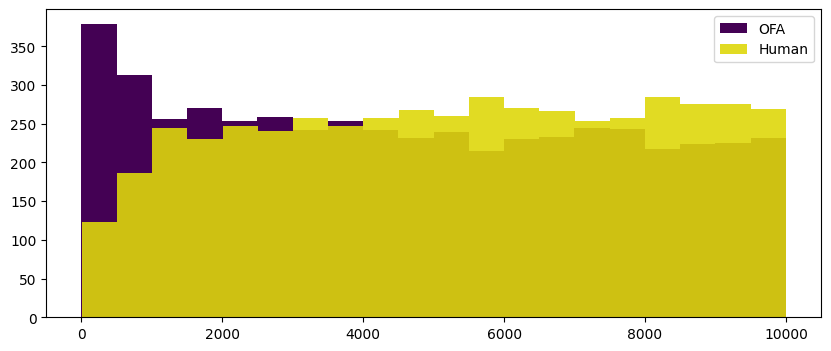

In [151]:
scores, order = combine_scores_full([[score.F1 for score in bert_scores], 
                                     [score.F1 for score in h_bert_scores]])
new_order = sorted(zip(scores, order))
new_order = [p[1] for p in new_order]
plot(new_order, "bert_OFA-vs-human.pdf")

In [152]:
stats.spearmanr(order, new_order)

SignificanceResult(statistic=0.0796, pvalue=1.5656224471969547e-15)